In [79]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.disable_eager_execution()
tf.compat.v1.random.set_random_seed(1234)

In [80]:
df = pd.read_csv('../Data/single_feature.csv', parse_dates=True, index_col=['Timestamp'])
df = df['2019-03':'2019-04'][['Temp_Mod']]
df = df.resample('60Min').mean()
df = df.fillna(df.bfill())
df.head()

,Temp_Mod
Timestamp,
2019-03-01 00:00:00,23.790909
2019-03-01 01:00:00,23.836364
2019-03-01 02:00:00,23.645455
2019-03-01 03:00:00,23.644444
2019-03-01 04:00:00,23.850000


In [81]:
minmax = MinMaxScaler().fit(df) # Close index
df_log = minmax.transform(df) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.277082
1,0.278846
2,0.271434
3,0.271395
4,0.279376


In [82]:
test_size = 24
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((1464, 1), (1440, 1), (24, 1))

In [83]:
def encoder_block(inp, n_hidden, filter_size):
    inp = tf.expand_dims(inp, 2)
    inp = tf.pad(
        inp,
        [
            [0, 0],
            [(filter_size[0] - 1) // 2, (filter_size[0] - 1) // 2],
            [0, 0],
            [0, 0],
        ],
    )
    conv = tf.compat.v1.layers.conv2d(
        inp, n_hidden, filter_size, padding = 'VALID', activation = None
    )
    conv = tf.squeeze(conv, 2)
    return conv


def decoder_block(inp, n_hidden, filter_size):
    inp = tf.expand_dims(inp, 2)
    inp = tf.pad(inp, [[0, 0], [filter_size[0] - 1, 0], [0, 0], [0, 0]])
    conv = tf.compat.v1.layers.conv2d(
        inp, n_hidden, filter_size, padding = 'VALID', activation = None
    )
    conv = tf.squeeze(conv, 2)
    return conv


def glu(x):
    return tf.multiply(
        x[:, :, : tf.shape(x)[2] // 2],
        tf.sigmoid(x[:, :, tf.shape(x)[2] // 2 :]),
    )


def layer(inp, conv_block, kernel_width, n_hidden, residual = None):
    z = conv_block(inp, n_hidden, (kernel_width, 1))
    return glu(z) + (residual if residual is not None else 0)

class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        kernel_size = 3,
        n_attn_heads = 16,
        dropout = 0.9,
    ):
        self.X = tf.compat.v1.placeholder(tf.float32, (None, None, size))
        self.Y = tf.compat.v1.placeholder(tf.float32, (None, output_size))

        encoder_embedded = tf.compat.v1.layers.dense(self.X, size_layer)

        e = tf.identity(encoder_embedded)
        for i in range(num_layers):
            z = layer(
                encoder_embedded,
                encoder_block,
                kernel_size,
                size_layer * 2,
                encoder_embedded,
            )
            z = tf.compat.v1.nn.dropout(z, keep_prob = dropout)
            encoder_embedded = z

        encoder_output, output_memory = z, z + e
        g = tf.identity(encoder_embedded)

        for i in range(num_layers):
            attn_res = h = layer(
                encoder_embedded,
                decoder_block,
                kernel_size,
                size_layer * 2,
                residual = tf.zeros_like(encoder_embedded),
            )
            C = []
            for j in range(n_attn_heads):
                h_ = tf.compat.v1.layers.dense(h, size_layer // n_attn_heads)
                g_ = tf.compat.v1.layers.dense(g, size_layer // n_attn_heads)
                zu_ = tf.compat.v1.layers.dense(
                    encoder_output, size_layer // n_attn_heads
                )
                ze_ = tf.compat.v1.layers.dense(output_memory, size_layer // n_attn_heads)

                d = tf.compat.v1.layers.dense(h_, size_layer // n_attn_heads) + g_
                dz = tf.matmul(d, tf.transpose(zu_, [0, 2, 1]))
                a = tf.nn.softmax(dz)
                c_ = tf.matmul(a, ze_)
                C.append(c_)

            c = tf.concat(C, 2)
            h = tf.compat.v1.layers.dense(attn_res + c, size_layer)
            h = tf.compat.v1.nn.dropout(h, keep_prob = dropout)
            encoder_embedded = h

        encoder_embedded = tf.sigmoid(encoder_embedded[-1])
        self.logits = tf.compat.v1.layers.dense(encoder_embedded, output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [84]:
simulation_size=3
num_layers = 1
size_layer = 128
timestamp = test_size
epoch = 300
dropout_rate = 0.7
future_day = test_size
learning_rate = 1e-3

In [85]:
def forecast():
    tf.compat.v1.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], 
        dropout = dropout_rate
    )
    sess = tf.compat.v1.InteractiveSession()
    sess.run(tf.compat.v1.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, _, loss = sess.run(
                [modelnn.logits, modelnn.optimizer, modelnn.cost],
                feed_dict = {modelnn.X: batch_x, modelnn.Y: batch_y},
            )        
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                )
            },
        )
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0)
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0)
            },
        )
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    tf.compat.v1.InteractiveSession.close(sess)
    
    return deep_future[-test_size:]

In [86]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())
    #tf.keras.utils.plot_model(model_LSTM, to_file='model.png', show_shapes=True, show_layer_names=True, dpi=80)InteractiveSession

simulation 1


c:\users\carlos\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\client\session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [02:16<00:00,  2.20it/s, acc=98.4, cost=0.00058] 


simulation 2


c:\users\carlos\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\client\session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [02:12<00:00,  2.27it/s, acc=98.5, cost=0.000528]


simulation 3


c:\users\carlos\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\client\session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [02:10<00:00,  2.29it/s, acc=98.4, cost=0.000609]


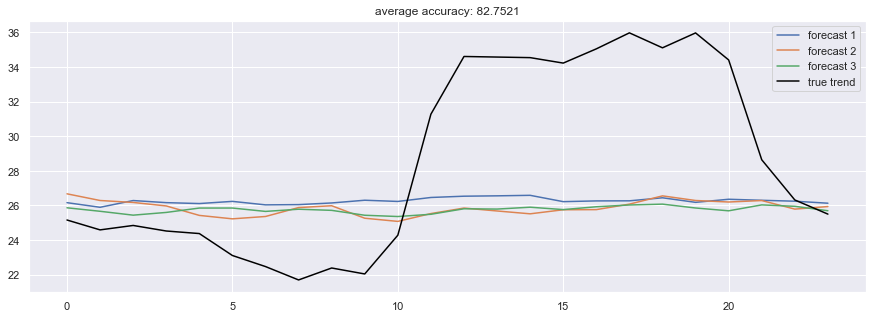

In [87]:
accuracies = [calculate_accuracy(df['Temp_Mod'].iloc[-test_size:].values, r) for r in results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['Temp_Mod'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))
plt.show()